In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from scipy.special import expit as logistic

# データの生成
N = 400
rng = np.random.default_rng(58)
true_intercept = 0.2
true_slope = 1.0
X = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * X)
Y = rng.binomial(1, true_p)

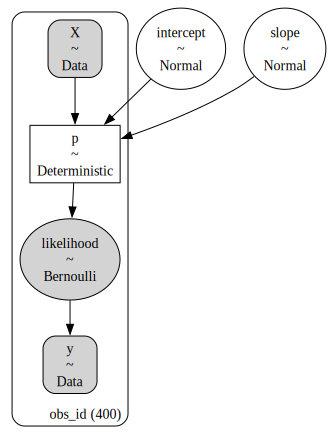

In [3]:
with pm.Model() as model:
    # データの定義
    X = pm.Data("X",X,dims="obs_id")
    y = pm.Data('y',Y,dims="obs_id")
    # パラメータの事前分布の設定
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    slope = pm.Normal("slope", mu=0, sigma=10)
    # ロジスティック回帰モデルの定義
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(intercept + slope * X),
        dims="obs_id",
    )
    # 尤度関数の定義
    likelihood = pm.Bernoulli(
        "likelihood",
        p=p,
        observed=y,
        dims="obs_id",
        )
pm.model_to_graphviz(model)

Sampling: [intercept, likelihood, slope]


<Axes: xlabel='likelihood'>

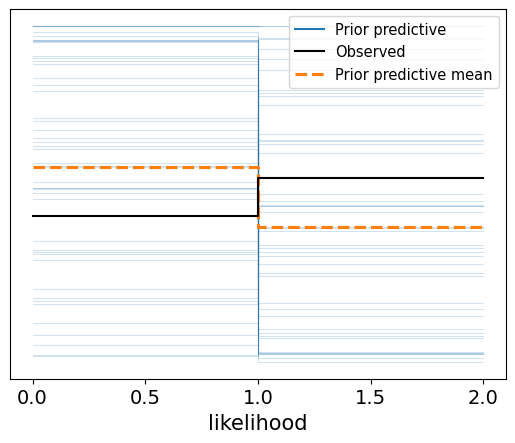

In [5]:
# 事前分布からのサンプリング
with model:
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)
az.plot_ppc(idata, observed=True, group="prior")

In [7]:
# MCMCサンプリング
with model:
    idata = pm.sample(
        3000,
        tune=1000,
        nuts_sampler="numpyro",
        chains=4,
        idata_kwargs={"log_likelihood": True},
        random_seed=42,
        target_accept=0.90,
        return_inferencedata=True
        )

az.summary(idata, round_to=2)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.29,0.11,0.08,0.50,0.0,0.0,7591.09,6849.78,1.0
slope,1.22,0.15,0.95,1.49,0.0,0.0,8287.09,7022.74,1.0
p[0],0.40,0.03,0.34,0.46,0.0,0.0,7807.77,7280.30,1.0
p[1],0.60,0.03,0.55,0.65,0.0,0.0,7634.19,6951.83,1.0
p[2],0.10,0.03,0.05,0.15,0.0,0.0,8473.09,6821.72,1.0
...,...,...,...,...,...,...,...,...,...
p[395],0.66,0.03,0.60,0.71,0.0,0.0,7756.68,6872.83,1.0
p[396],0.15,0.03,0.09,0.21,0.0,0.0,8429.07,6810.47,1.0
p[397],0.34,0.03,0.28,0.40,0.0,0.0,7931.54,7179.89,1.0
p[398],0.56,0.03,0.51,0.61,0.0,0.0,7578.74,6891.23,1.0


array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

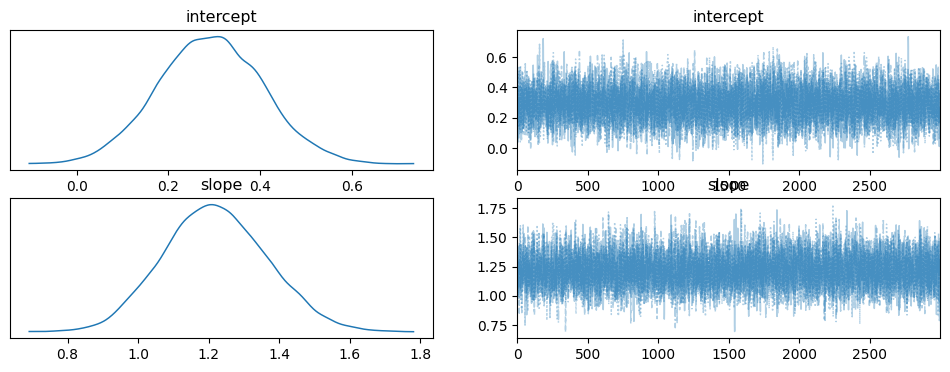

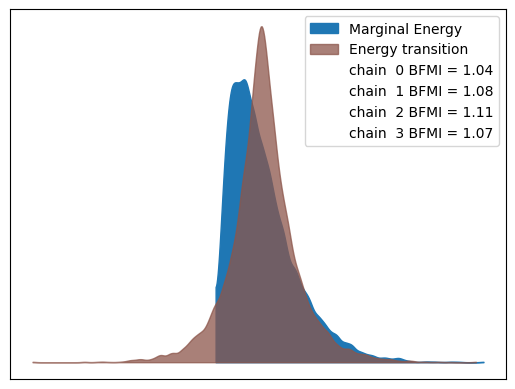

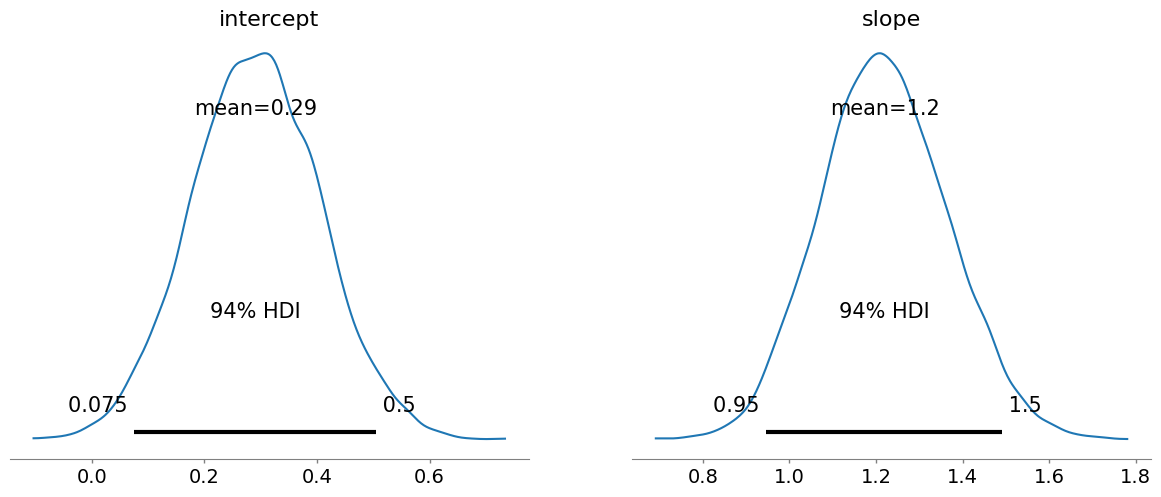

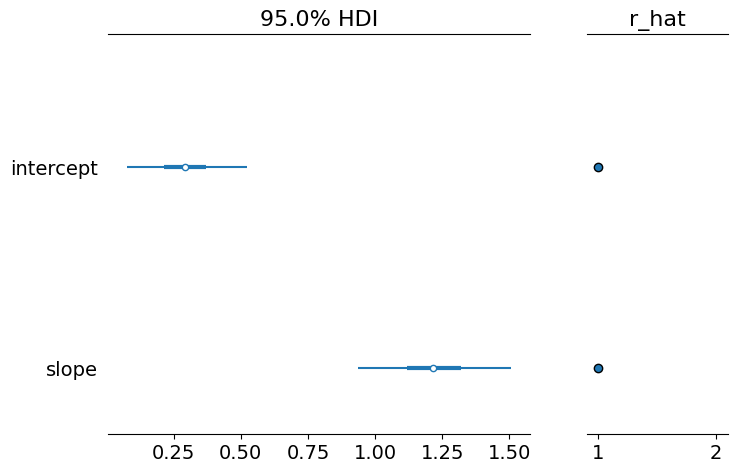

In [14]:
az.plot_trace(idata, combined=True, var_names=["intercept", "slope"])
az.plot_energy(idata)
az.plot_posterior(idata, var_names=["intercept", "slope"])
az.plot_forest(idata, var_names=["intercept", "slope"], combined=True, hdi_prob=0.95, r_hat=True)

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

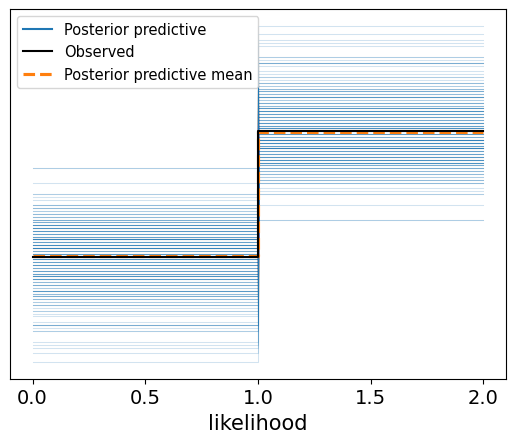

In [15]:
# 事後分布からのサンプリング
with model:
    idata.extend(pm.sample_posterior_predictive(idata))
az.plot_ppc(idata, observed=True,num_pp_samples=200)